***One possible way to improve the model is Transfer Learning:***  
Take an existing model's pre-learned patterns from one problem and tweak them to suit your own problem. Eg taking a model trained on pictures of cars to recognize trucks. 

* Pre-Trained models -> Foundational Models.

#### ***Transfer Learning:***

- Helps to leverage an existing neural network architecture proven to work on problems similar to our own, or a working architecture which has already learned patterns on similar data to our own (often results in great results with less data).
- e.g. Pre-Trained EfficientNet works well on computer vision tasks, so we can extract/tune weights to suit our own problem.
- When simply considering the overall costs of pre-training and subsequent training or fine-tuning procedures together, the cost of pre-training usually dominates, often by orders of magnitude. From the vantage point of a researcher aiming to improve model architectures or pre-training schemes, the pre-training costs might therefore be most relevant. 
- Most practitioners, however, rarely, if ever perform pre-training on today’s largest datasets but instead use some of the many publicly available parameter sets. For them the costs of fine-tuning, adaptation or training a task-specific model from scratch would be of most interest.
- Transfer Learning is still the best option, even if the data used for pre-training is only weakly related to downstream task (the specific task the model is being fine-tuned for). This means that even if there isnt a perfect match between the pre-training dataset and the target dataset, transfer learning can still yield effective results.

- Few Insights on Training Data vs Data Augmentation:
    - The analysis suggests that when comparing similarly performing pre-trained models, it is preferable to choose a model trained with more data rather than one that relies heavily on data augmentation techniques.
    - This emphasizes the importance of having access to a larger, diverse dataset during training rather than artificially expanding smaller datasets.

source: [How to train your ViT? Data, Augmentation, and Regularization in Vision Transformers]  https://arxiv.org/abs/2106.10270

In [1]:
import torch, torchvision
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


In [2]:
import os
import sys

# Get the parent directory (where `src` is located)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from src import engine, utils, transform
from src.models.TinyVGG import TinyVGGV1
from src.data_setup import create_dataloaders
from timeit import default_timer as timer

# setting up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

c:\Users\HP\Desktop\Deep_Learning\Foodie-Vision\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
!nvidia-smi

Sat Mar  8 22:11:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.19                 Driver Version: 561.19         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   45C    P0              8W /   60W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### 1) Setting up our Dataset

#### 1.1 Manual Creation of transforms for torchvision.models

We will need to use the transforms in a certain way as written below to have the same data distribution of the pre-trained models.  

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize:

In [3]:
train_dir = f"../dataset/MiniFood101/train"
test_dir = f"../dataset/MiniFood101/test"

# makes sure images have the same distribution as ImageNet
# the foundational models are trained on ImageNet dataset

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([transforms.Resize(size=(224,224)),
                                        transforms.ToTensor(),
                                        normalize])

train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                    test_dir=test_dir,
                                                                    train_transform=manual_transforms,
                                                                    test_transform=manual_transforms,
                                                                    batch_size=25,
                                                                    num_workers=1)
# lets see our data
img,label = next(iter(train_dataloader))
print(img.shape,label,"The image is of: ",class_names[label[24]])

torch.Size([25, 3, 224, 224]) tensor([22, 33, 54, 70, 80, 23, 15, 74, 38, 74, 89, 15, 77, 98, 56, 71, 82, 52,
        46, 70, 52, 89, 34, 60, 19]) The image is of:  chicken_quesadilla


#### 1.2 Auto-Creation of transforms for torchvision.models

We will be using EfficientNet Architecture to solve our problem.

Accuracies reported on ImageNet-1K [1000 classes dataset]:  

Acc@1: 77.692%, Acc@5: 93.532%, Params: 5.3M, GFLOPS: 0.39

- Acc@1 (Top-1 Accuracy):
    - The percentage of times the model’s top predicted class is correct.
    - Top-1 Accuracy = (Correct Predictions/Total Predictions)*100
    - Acc@1 = 77.692, the model correctly predicted the exact class 77.692% of the time.

- Acc@5 (Top-5 Accuracy)"
    - The percentage of times the correct class is among the top 5 predictions.
    - The correct class should be among the top 5 probability for predicted classes.
    - Used for multi-class classification problems where multiple choices are possible [1000s of classes].
    - Acc@5 = 93.532, then in 93.532% of cases, the correct class was in the model’s top 5 predictions.

- Params (Number of Parameters)
    - The total trainable parameters in the model.
    - A measure of model complexity (higher params → more computation & memory needed).
    - 5.3M means 5.3 million trainable parameters.
    - GFLOPS (Giga Floating Point Operations Per Second).

- GFLOPS (Measures computational cost).
    - Indicates the number of billion (Giga) floating-point operations needed per forward pass.
    - Lower GFLOPS = more efficient model.
    - 0.39 GFLOPS means the model requires 0.39 billion operations per forward pass.

source: https://pytorch.org/vision/0.21/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.EfficientNet_B0_Weights

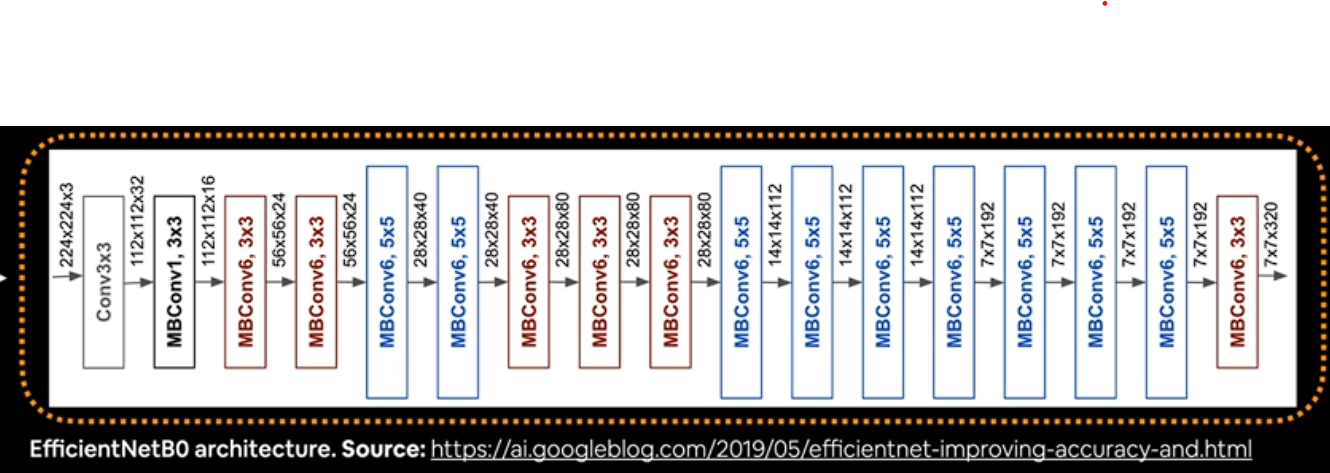

In [34]:
# lets get the pre-trained model weights
weights_effnetb0 = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1

# getting the transforms used to create the pre-trained weights.
auto_transforms_effnetb0 = weights_effnetb0.transforms()
auto_transforms_effnetb0

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [36]:
train_dataloader_effnetb0, test_dataloader_effnetb0, class_names = create_dataloaders(train_dir=train_dir,
                                                                    test_dir=test_dir,
                                                                    train_transform=auto_transforms_effnetb0,
                                                                    test_transform=auto_transforms_effnetb0,
                                                                    batch_size=5,
                                                                    num_workers=1)
# lets see our data
# img,label = next(iter(train_dataloader_effnetb0))
# print(img.shape,label,"The image is of: ",class_names[label[24]])
# plt.imshow(img[24].permute(1,2,0))
# plt.title(class_names[label[24]])
# plt.axis('off')

### 2) Getting the Pre-Trained Model.

- PyTorch domain libraries.
- Libraries like 'timm' (torch image models)
- HuggingFace Hub
- Paperswithcode

Which Pre-Trained model to use ?

Based on the idea of transfer learning, take a best performing model in the similar problem space and customize it to our own problem.

- Things to consider:
    - Speed
    - Size
    - Performance 
- Where does the model exist ?
    - in the server or present in the device itself.

So we will be using EffNetB0, in-terms of performance vs size and also to deploy it on mobile device this is our best option.

In [37]:
model_effnetb0 = torchvision.models.efficientnet_b0(weights=weights_effnetb0)
model_effnetb0

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [38]:
# Feature Layers
# Extracts Features from the image
model_effnetb0.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [39]:
# Turns Feature into a Feature Vector
model_effnetb0.avgpool

AdaptiveAvgPool2d(output_size=1)

In [40]:
model_effnetb0.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

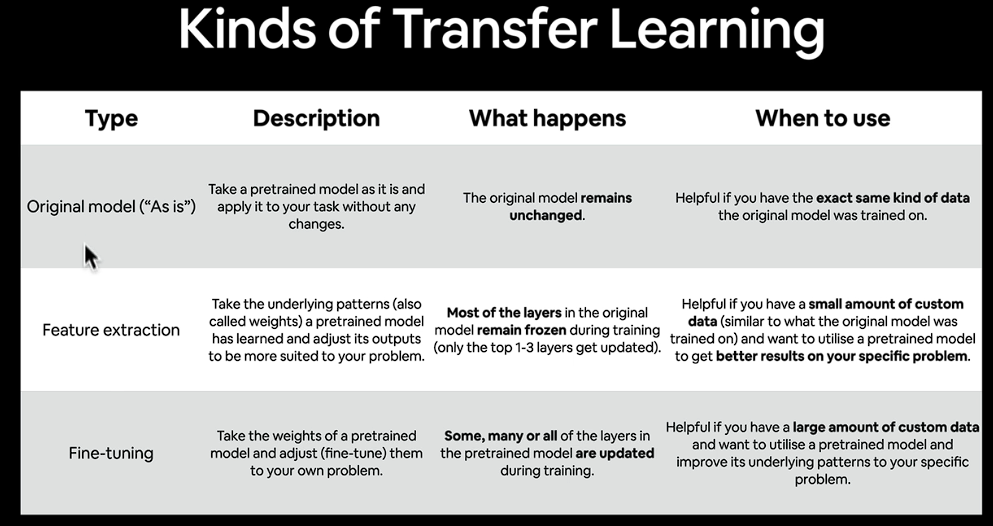

Summary of the pre-trained model

In [41]:
from torchinfo import summary 

# summary(model=model_effnetb0,
#         input_size = (1,3,224,224),
#         col_names=["input_size","output_size","num_params","trainable"],
#         col_width=20,
#         row_settings=["var_names"])

So we will do feature extraction type transfer learning
- Freeze the Base layer.
- Change the Output layer.


In [ ]:
# We will be freezing all of the feature layer while training our model, 
# hence these blocks weights will not get updated.

for param in model_effnetb0.features.parameters():
    param.requires_grad = False 

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# we will only update the classifier head of our model to suit the problem.
model_effnetb0.classifier = nn.Sequential(nn.Dropout(p=0.2,inplace=True),
                                            nn.Linear(in_features=1280,out_features=640),
                                            nn.ELU(0.01),
                                            nn.Linear(in_features=640,out_features=len(class_names)))

model_effnetb0 = model_effnetb0.to(device)
summary(model=model_effnetb0,
        input_size = (1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3. Train our EfficientNetB0 Model

In [ ]:
import time
from tqdm.auto import tqdm
from src.utils import create_writer

NUM_EPOCHS = 150
BATCH_SIZE = 5
LEARNING_RATE = 0.001
extra_path = "epochs=" + str(NUM_EPOCHS) + "/batch_size=" + str(BATCH_SIZE) + "/lr=" + str(LEARNING_RATE).replace('.','_') + '/'

torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=model_effnetb0.parameters(),lr=LEARNING_RATE)
writer = create_writer(experiment_name="MiniFood101",
                       model_name="FE_EffNetB0", # Feature Extraction
                       extra=extra_path)

print("Training Model EffNet_B0 [Only linear classifier parameters trainable]")
start_time = timer()
model_effnetb0_results = engine.initiate_training(model=model_effnetb0,
                                        train_dataloader=train_dataloader_effnetb0,
                                        test_dataloader=test_dataloader_effnetb0,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        # scheduler=scheduler1,
                                        epochs=NUM_EPOCHS,
                                        device=device,
                                        writer=writer)       
end_time = timer()

model_training_time = end_time-start_time

model_target_dir = '../models'
formatted_lr = f"lr{str(LEARNING_RATE).rstrip('0').rstrip('.').replace('.', '_')}"
model_name = "FE_EffNet_B0_ep" + str(NUM_EPOCHS) + "_bs" + str(BATCH_SIZE) + "_" + formatted_lr + ".pth"

utils.save_model(model=model_effnetb0,
                 target_dir=model_target_dir,
                 model_name=model_name)

utils.upload_performance(model_name='FE_EffNet_B0',
                        target_dir='../model_performance/',
                        batch_size=BATCH_SIZE,
                        learning_rate=LEARNING_RATE,
                        training_time= model_training_time,
                        model_results=model_effnetb0_results)

Training Model EffnetB0


Epoch 0: Train Loss: 2.3355 | Test Loss: 2.4274 | Train Accuracy: 52.9769 | Test Accuracy: 44.3564


Epoch 1: Train Loss: 2.1680 | Test Loss: 2.2394 | Train Accuracy: 50.6271 | Test Accuracy: 47.9604


Epoch 2: Train Loss: 1.9168 | Test Loss: 2.1784 | Train Accuracy: 54.8119 | Test Accuracy: 48.1980


Epoch 3: Train Loss: 1.7354 | Test Loss: 2.1043 | Train Accuracy: 58.6535 | Test Accuracy: 49.3069


Epoch 4: Train Loss: 1.6052 | Test Loss: 2.0938 | Train Accuracy: 61.2541 | Test Accuracy: 49.2673


Epoch 5: Train Loss: 1.4832 | Test Loss: 2.0698 | Train Accuracy: 64.0792 | Test Accuracy: 48.2376


Epoch 6: Train Loss: 1.3769 | Test Loss: 2.0697 | Train Accuracy: 66.4818 | Test Accuracy: 48.8713


Epoch 7: Train Loss: 1.3073 | Test Loss: 2.0774 | Train Accuracy: 68.3168 | Test Accuracy: 48.5149


Epoch 8: Train Loss: 1.2553 | Test Loss: 2.0904 | Train Accuracy: 68.9373 | Test Accuracy: 49.1089


Epoch 9: Train Loss: 1.1717 | Test Loss: 2.0603 | Train Accuracy: 71.1683 | Test Accuracy: 48.8317


Epoch 10: Train Loss: 1.1097 | Test Loss: 2.0904 | Train Accuracy: 72.8581 | Test Accuracy: 49.1485


Epoch 11: Train Loss: 1.0761 | Test Loss: 2.0848 | Train Accuracy: 72.7129 | Test Accuracy: 49.1881


Epoch 12: Train Loss: 1.0412 | Test Loss: 2.0891 | Train Accuracy: 73.8878 | Test Accuracy: 48.1980


Epoch 13: Train Loss: 0.9875 | Test Loss: 2.0957 | Train Accuracy: 75.2871 | Test Accuracy: 48.9109


Epoch 14: Train Loss: 0.9722 | Test Loss: 2.1285 | Train Accuracy: 75.2871 | Test Accuracy: 48.0000


Epoch 15: Train Loss: 0.9201 | Test Loss: 2.1199 | Train Accuracy: 76.3564 | Test Accuracy: 48.1188


Epoch 16: Train Loss: 0.9002 | Test Loss: 2.1434 | Train Accuracy: 76.8581 | Test Accuracy: 47.8416


Epoch 17: Train Loss: 0.8827 | Test Loss: 2.1457 | Train Accuracy: 77.2277 | Test Accuracy: 47.6832


Epoch 18: Train Loss: 0.8497 | Test Loss: 2.1629 | Train Accuracy: 78.5743 | Test Accuracy: 47.1287


Epoch 19: Train Loss: 0.8284 | Test Loss: 2.1684 | Train Accuracy: 78.7063 | Test Accuracy: 47.4455


Epoch 20: Train Loss: 0.8088 | Test Loss: 2.1537 | Train Accuracy: 78.5347 | Test Accuracy: 48.7921


Epoch 21: Train Loss: 0.7906 | Test Loss: 2.1844 | Train Accuracy: 79.1155 | Test Accuracy: 48.5545


Epoch 22: Train Loss: 0.7835 | Test Loss: 2.1746 | Train Accuracy: 79.5512 | Test Accuracy: 47.9208


Epoch 23: Train Loss: 0.7585 | Test Loss: 2.2227 | Train Accuracy: 80.2772 | Test Accuracy: 47.0891


Epoch 24: Train Loss: 0.7519 | Test Loss: 2.2111 | Train Accuracy: 80.3036 | Test Accuracy: 47.9604


Epoch 25: Train Loss: 0.7249 | Test Loss: 2.2526 | Train Accuracy: 81.3201 | Test Accuracy: 47.8020


Epoch 26: Train Loss: 0.7089 | Test Loss: 2.2409 | Train Accuracy: 81.3333 | Test Accuracy: 48.0792


Epoch 27: Train Loss: 0.6938 | Test Loss: 2.2371 | Train Accuracy: 81.7162 | Test Accuracy: 48.5941


Epoch 28: Train Loss: 0.6678 | Test Loss: 2.2372 | Train Accuracy: 82.2046 | Test Accuracy: 48.2772


Epoch 29: Train Loss: 0.6679 | Test Loss: 2.2521 | Train Accuracy: 81.7822 | Test Accuracy: 48.0792


Epoch 30: Train Loss: 0.6902 | Test Loss: 2.2909 | Train Accuracy: 81.0957 | Test Accuracy: 47.4059


Epoch 31: Train Loss: 0.6519 | Test Loss: 2.2999 | Train Accuracy: 82.4290 | Test Accuracy: 48.0000


Epoch 32: Train Loss: 0.6346 | Test Loss: 2.3116 | Train Accuracy: 82.7063 | Test Accuracy: 47.4851


Epoch 33: Train Loss: 0.6501 | Test Loss: 2.2882 | Train Accuracy: 82.3366 | Test Accuracy: 47.6832


Epoch 34: Train Loss: 0.6343 | Test Loss: 2.3084 | Train Accuracy: 82.4422 | Test Accuracy: 47.7228


Epoch 35: Train Loss: 0.6164 | Test Loss: 2.3272 | Train Accuracy: 83.3399 | Test Accuracy: 46.9307


Epoch 36: Train Loss: 0.6081 | Test Loss: 2.3527 | Train Accuracy: 83.4851 | Test Accuracy: 47.3267


Epoch 37: Train Loss: 0.6085 | Test Loss: 2.3539 | Train Accuracy: 82.9835 | Test Accuracy: 46.4950


Epoch 38: Train Loss: 0.6060 | Test Loss: 2.3395 | Train Accuracy: 83.2079 | Test Accuracy: 46.9307


Epoch 39: Train Loss: 0.6107 | Test Loss: 2.3422 | Train Accuracy: 83.0759 | Test Accuracy: 46.6139


Epoch 40: Train Loss: 0.5945 | Test Loss: 2.3711 | Train Accuracy: 83.6832 | Test Accuracy: 47.0495


Epoch 41: Train Loss: 0.5720 | Test Loss: 2.3538 | Train Accuracy: 84.0528 | Test Accuracy: 47.4455


Epoch 42: Train Loss: 0.6216 | Test Loss: 2.3628 | Train Accuracy: 82.4026 | Test Accuracy: 47.2475


Epoch 43: Train Loss: 0.5985 | Test Loss: 2.4015 | Train Accuracy: 83.2079 | Test Accuracy: 46.7327


Epoch 44: Train Loss: 0.5897 | Test Loss: 2.3626 | Train Accuracy: 83.1155 | Test Accuracy: 47.1683


Epoch 45: Train Loss: 0.5771 | Test Loss: 2.3894 | Train Accuracy: 83.8680 | Test Accuracy: 47.4059


Epoch 46: Train Loss: 0.5687 | Test Loss: 2.3872 | Train Accuracy: 83.7492 | Test Accuracy: 47.2475


Epoch 47: Train Loss: 0.5515 | Test Loss: 2.4087 | Train Accuracy: 84.4488 | Test Accuracy: 47.5644


Epoch 48: Train Loss: 0.5628 | Test Loss: 2.4136 | Train Accuracy: 83.8812 | Test Accuracy: 46.9307


Epoch 49: Train Loss: 0.5643 | Test Loss: 2.4592 | Train Accuracy: 83.6436 | Test Accuracy: 46.8119


Epoch 50: Train Loss: 0.5533 | Test Loss: 2.4721 | Train Accuracy: 84.5017 | Test Accuracy: 46.2970


Epoch 51: Train Loss: 0.5429 | Test Loss: 2.4589 | Train Accuracy: 84.5809 | Test Accuracy: 46.2970


Epoch 52: Train Loss: 0.5432 | Test Loss: 2.4562 | Train Accuracy: 84.8449 | Test Accuracy: 46.8911


Epoch 53: Train Loss: 0.5515 | Test Loss: 2.4688 | Train Accuracy: 84.3564 | Test Accuracy: 46.6535


Epoch 54: Train Loss: 0.5405 | Test Loss: 2.4569 | Train Accuracy: 84.6997 | Test Accuracy: 46.8515


Epoch 55: Train Loss: 0.5306 | Test Loss: 2.5261 | Train Accuracy: 84.7129 | Test Accuracy: 46.2970


Epoch 56: Train Loss: 0.5332 | Test Loss: 2.4728 | Train Accuracy: 84.6601 | Test Accuracy: 46.8515


Epoch 57: Train Loss: 0.5306 | Test Loss: 2.4973 | Train Accuracy: 84.7921 | Test Accuracy: 47.0099


Epoch 58: Train Loss: 0.5274 | Test Loss: 2.4726 | Train Accuracy: 84.7393 | Test Accuracy: 47.5644


Epoch 59: Train Loss: 0.5337 | Test Loss: 2.4845 | Train Accuracy: 84.6337 | Test Accuracy: 47.2871


Epoch 60: Train Loss: 0.5238 | Test Loss: 2.5098 | Train Accuracy: 84.8053 | Test Accuracy: 46.2970


Epoch 61: Train Loss: 0.5384 | Test Loss: 2.4958 | Train Accuracy: 83.8416 | Test Accuracy: 46.6931


Epoch 62: Train Loss: 0.5061 | Test Loss: 2.4884 | Train Accuracy: 85.2409 | Test Accuracy: 47.3267


Epoch 63: Train Loss: 0.5092 | Test Loss: 2.5099 | Train Accuracy: 85.5314 | Test Accuracy: 47.0891


Epoch 64: Train Loss: 0.5232 | Test Loss: 2.5296 | Train Accuracy: 85.0033 | Test Accuracy: 47.0891


Epoch 65: Train Loss: 0.5248 | Test Loss: 2.5276 | Train Accuracy: 84.2772 | Test Accuracy: 46.4158


Epoch 66: Train Loss: 0.5273 | Test Loss: 2.5215 | Train Accuracy: 84.3828 | Test Accuracy: 46.8515


Epoch 67: Train Loss: 0.4909 | Test Loss: 2.5631 | Train Accuracy: 85.5710 | Test Accuracy: 46.2178


Epoch 68: Train Loss: 0.5138 | Test Loss: 2.5581 | Train Accuracy: 84.7129 | Test Accuracy: 45.7822


Epoch 69: Train Loss: 0.5050 | Test Loss: 2.5657 | Train Accuracy: 85.1749 | Test Accuracy: 47.0495


Epoch 70: Train Loss: 0.5268 | Test Loss: 2.5580 | Train Accuracy: 84.5149 | Test Accuracy: 46.7327


Epoch 71: Train Loss: 0.4934 | Test Loss: 2.5761 | Train Accuracy: 85.4917 | Test Accuracy: 46.4950


Epoch 72: Train Loss: 0.5021 | Test Loss: 2.5934 | Train Accuracy: 85.6898 | Test Accuracy: 46.8119


Epoch 73: Train Loss: 0.4825 | Test Loss: 2.5685 | Train Accuracy: 85.9538 | Test Accuracy: 46.6535


Epoch 74: Train Loss: 0.5029 | Test Loss: 2.6189 | Train Accuracy: 85.2805 | Test Accuracy: 46.2970


Epoch 75: Train Loss: 0.4985 | Test Loss: 2.6132 | Train Accuracy: 85.4521 | Test Accuracy: 46.2970


Epoch 76: Train Loss: 0.4708 | Test Loss: 2.6135 | Train Accuracy: 86.5479 | Test Accuracy: 46.2178


Epoch 77: Train Loss: 0.4949 | Test Loss: 2.6187 | Train Accuracy: 85.3465 | Test Accuracy: 46.3762


Epoch 78: Train Loss: 0.4941 | Test Loss: 2.6053 | Train Accuracy: 85.3465 | Test Accuracy: 46.3762


Epoch 79: Train Loss: 0.5089 | Test Loss: 2.6225 | Train Accuracy: 84.7789 | Test Accuracy: 46.6931


Epoch 80: Train Loss: 0.5034 | Test Loss: 2.6170 | Train Accuracy: 84.8581 | Test Accuracy: 46.6535


Epoch 81: Train Loss: 0.4989 | Test Loss: 2.6352 | Train Accuracy: 85.3597 | Test Accuracy: 46.3762


Epoch 82: Train Loss: 0.4921 | Test Loss: 2.6347 | Train Accuracy: 85.4785 | Test Accuracy: 46.0594


Epoch 83: Train Loss: 0.4864 | Test Loss: 2.6270 | Train Accuracy: 85.4521 | Test Accuracy: 45.9010


Epoch 84: Train Loss: 0.4848 | Test Loss: 2.6525 | Train Accuracy: 85.1881 | Test Accuracy: 46.2178


Epoch 85: Train Loss: 0.4753 | Test Loss: 2.6728 | Train Accuracy: 85.8482 | Test Accuracy: 46.2178


Epoch 86: Train Loss: 0.4649 | Test Loss: 2.6559 | Train Accuracy: 86.6799 | Test Accuracy: 45.6238


Epoch 87: Train Loss: 0.4935 | Test Loss: 2.6408 | Train Accuracy: 85.5050 | Test Accuracy: 46.4158


Epoch 88: Train Loss: 0.4763 | Test Loss: 2.6448 | Train Accuracy: 85.9406 | Test Accuracy: 46.3366


Epoch 89: Train Loss: 0.4776 | Test Loss: 2.6594 | Train Accuracy: 85.8878 | Test Accuracy: 46.4554


Epoch 90: Train Loss: 0.4699 | Test Loss: 2.6640 | Train Accuracy: 86.2178 | Test Accuracy: 46.4950


Epoch 91: Train Loss: 0.4642 | Test Loss: 2.6941 | Train Accuracy: 86.3762 | Test Accuracy: 46.7327


Epoch 92: Train Loss: 0.4810 | Test Loss: 2.7080 | Train Accuracy: 85.7822 | Test Accuracy: 45.4653


Epoch 93: Train Loss: 0.4834 | Test Loss: 2.6902 | Train Accuracy: 85.4521 | Test Accuracy: 47.0891


Epoch 94: Train Loss: 0.4861 | Test Loss: 2.7202 | Train Accuracy: 85.8878 | Test Accuracy: 46.9307


Epoch 95: Train Loss: 0.4769 | Test Loss: 2.7183 | Train Accuracy: 86.0726 | Test Accuracy: 46.1386


Epoch 96: Train Loss: 0.4700 | Test Loss: 2.7146 | Train Accuracy: 86.0594 | Test Accuracy: 45.3861


Epoch 97: Train Loss: 0.4630 | Test Loss: 2.7377 | Train Accuracy: 86.1914 | Test Accuracy: 45.7030


Epoch 98: Train Loss: 0.4695 | Test Loss: 2.7376 | Train Accuracy: 86.3234 | Test Accuracy: 45.7822


Epoch 99: Train Loss: 0.4545 | Test Loss: 2.7136 | Train Accuracy: 86.7855 | Test Accuracy: 46.4554


Epoch 100: Train Loss: 0.4668 | Test Loss: 2.7571 | Train Accuracy: 86.3498 | Test Accuracy: 46.1782


Epoch 101: Train Loss: 0.4793 | Test Loss: 2.7568 | Train Accuracy: 85.9406 | Test Accuracy: 45.1881


Epoch 102: Train Loss: 0.4712 | Test Loss: 2.7555 | Train Accuracy: 85.7690 | Test Accuracy: 45.9010


Epoch 103: Train Loss: 0.4648 | Test Loss: 2.7817 | Train Accuracy: 85.8086 | Test Accuracy: 45.2673


Epoch 104: Train Loss: 0.4499 | Test Loss: 2.7756 | Train Accuracy: 86.3366 | Test Accuracy: 45.2673


Epoch 105: Train Loss: 0.4738 | Test Loss: 2.7499 | Train Accuracy: 85.5842 | Test Accuracy: 45.8614


Epoch 106: Train Loss: 0.4669 | Test Loss: 2.7657 | Train Accuracy: 86.2574 | Test Accuracy: 45.7030


Epoch 107: Train Loss: 0.4622 | Test Loss: 2.7775 | Train Accuracy: 86.1518 | Test Accuracy: 45.9406


Epoch 108: Train Loss: 0.4871 | Test Loss: 2.7745 | Train Accuracy: 85.5578 | Test Accuracy: 46.2178


Epoch 109: Train Loss: 0.4596 | Test Loss: 2.8180 | Train Accuracy: 86.0990 | Test Accuracy: 45.6634


Epoch 110: Train Loss: 0.4680 | Test Loss: 2.7806 | Train Accuracy: 85.8218 | Test Accuracy: 47.0891


Epoch 111: Train Loss: 0.4469 | Test Loss: 2.7669 | Train Accuracy: 86.4554 | Test Accuracy: 46.4554


Epoch 112: Train Loss: 0.4541 | Test Loss: 2.8029 | Train Accuracy: 86.3894 | Test Accuracy: 46.0198


Epoch 113: Train Loss: 0.4599 | Test Loss: 2.8388 | Train Accuracy: 86.0198 | Test Accuracy: 45.5050


Epoch 114: Train Loss: 0.4607 | Test Loss: 2.7854 | Train Accuracy: 86.3762 | Test Accuracy: 45.9010


Epoch 115: Train Loss: 0.4616 | Test Loss: 2.8274 | Train Accuracy: 86.0990 | Test Accuracy: 45.8614


Epoch 116: Train Loss: 0.4656 | Test Loss: 2.8149 | Train Accuracy: 86.0594 | Test Accuracy: 46.2178


Epoch 117: Train Loss: 0.4650 | Test Loss: 2.8386 | Train Accuracy: 85.9406 | Test Accuracy: 46.6535


Epoch 118: Train Loss: 0.4763 | Test Loss: 2.8220 | Train Accuracy: 86.0330 | Test Accuracy: 46.4554


Epoch 119: Train Loss: 0.4697 | Test Loss: 2.8252 | Train Accuracy: 85.7294 | Test Accuracy: 46.8515


Epoch 120: Train Loss: 0.4612 | Test Loss: 2.8511 | Train Accuracy: 86.2442 | Test Accuracy: 45.4257


Epoch 121: Train Loss: 0.4613 | Test Loss: 2.8498 | Train Accuracy: 85.7690 | Test Accuracy: 46.0198


Epoch 122: Train Loss: 0.4604 | Test Loss: 2.8315 | Train Accuracy: 86.1650 | Test Accuracy: 46.8515


Epoch 123: Train Loss: 0.4579 | Test Loss: 2.8164 | Train Accuracy: 86.4554 | Test Accuracy: 46.6931


Epoch 124: Train Loss: 0.4465 | Test Loss: 2.8491 | Train Accuracy: 86.6535 | Test Accuracy: 46.6535


Epoch 125: Train Loss: 0.4257 | Test Loss: 2.8663 | Train Accuracy: 87.2871 | Test Accuracy: 46.6139


Epoch 126: Train Loss: 0.4520 | Test Loss: 2.8468 | Train Accuracy: 86.3234 | Test Accuracy: 46.2178


Epoch 127: Train Loss: 0.4430 | Test Loss: 2.8382 | Train Accuracy: 86.8119 | Test Accuracy: 46.2574


Epoch 128: Train Loss: 0.4672 | Test Loss: 2.8528 | Train Accuracy: 85.8086 | Test Accuracy: 46.6535


Epoch 129: Train Loss: 0.4554 | Test Loss: 2.8593 | Train Accuracy: 86.6271 | Test Accuracy: 46.3366


Epoch 130: Train Loss: 0.4524 | Test Loss: 2.8740 | Train Accuracy: 86.4950 | Test Accuracy: 45.9010


Epoch 131: Train Loss: 0.4405 | Test Loss: 2.8781 | Train Accuracy: 86.3234 | Test Accuracy: 46.4554


Epoch 132: Train Loss: 0.4407 | Test Loss: 2.8604 | Train Accuracy: 85.9274 | Test Accuracy: 45.5842


Epoch 133: Train Loss: 0.4614 | Test Loss: 2.9015 | Train Accuracy: 85.9802 | Test Accuracy: 46.9703


Epoch 134: Train Loss: 0.4794 | Test Loss: 2.9097 | Train Accuracy: 85.5050 | Test Accuracy: 45.3861


Epoch 135: Train Loss: 0.4475 | Test Loss: 2.9076 | Train Accuracy: 86.7591 | Test Accuracy: 45.9802


Epoch 136: Train Loss: 0.4660 | Test Loss: 2.8819 | Train Accuracy: 85.8614 | Test Accuracy: 45.9802


Epoch 137: Train Loss: 0.4507 | Test Loss: 2.9027 | Train Accuracy: 86.1122 | Test Accuracy: 46.2574


Epoch 138: Train Loss: 0.4537 | Test Loss: 2.8940 | Train Accuracy: 85.8086 | Test Accuracy: 46.0198


Epoch 139: Train Loss: 0.4596 | Test Loss: 2.8760 | Train Accuracy: 86.2046 | Test Accuracy: 46.3366


Epoch 140: Train Loss: 0.4695 | Test Loss: 2.9042 | Train Accuracy: 85.9406 | Test Accuracy: 46.0198


Epoch 141: Train Loss: 0.4549 | Test Loss: 2.9124 | Train Accuracy: 86.7063 | Test Accuracy: 46.3762


Epoch 142: Train Loss: 0.4441 | Test Loss: 2.9146 | Train Accuracy: 86.3894 | Test Accuracy: 45.6634


Epoch 143: Train Loss: 0.4552 | Test Loss: 2.8991 | Train Accuracy: 86.1254 | Test Accuracy: 46.2178


Epoch 144: Train Loss: 0.4472 | Test Loss: 2.9037 | Train Accuracy: 86.6799 | Test Accuracy: 46.2970


Epoch 145: Train Loss: 0.4463 | Test Loss: 2.9081 | Train Accuracy: 86.4818 | Test Accuracy: 46.8515


Epoch 146: Train Loss: 0.4425 | Test Loss: 2.9107 | Train Accuracy: 86.5215 | Test Accuracy: 46.1386


Epoch 147: Train Loss: 0.4547 | Test Loss: 2.9463 | Train Accuracy: 86.6799 | Test Accuracy: 45.8614


Epoch 148: Train Loss: 0.4221 | Test Loss: 2.9403 | Train Accuracy: 87.2871 | Test Accuracy: 45.9802


Epoch 149: Train Loss: 0.4365 | Test Loss: 2.9080 | Train Accuracy: 86.9439 | Test Accuracy: 46.8119
Model results saved successfully! 🚀


### 4. Plotting Test vs Train Loss and Accuracy Curves

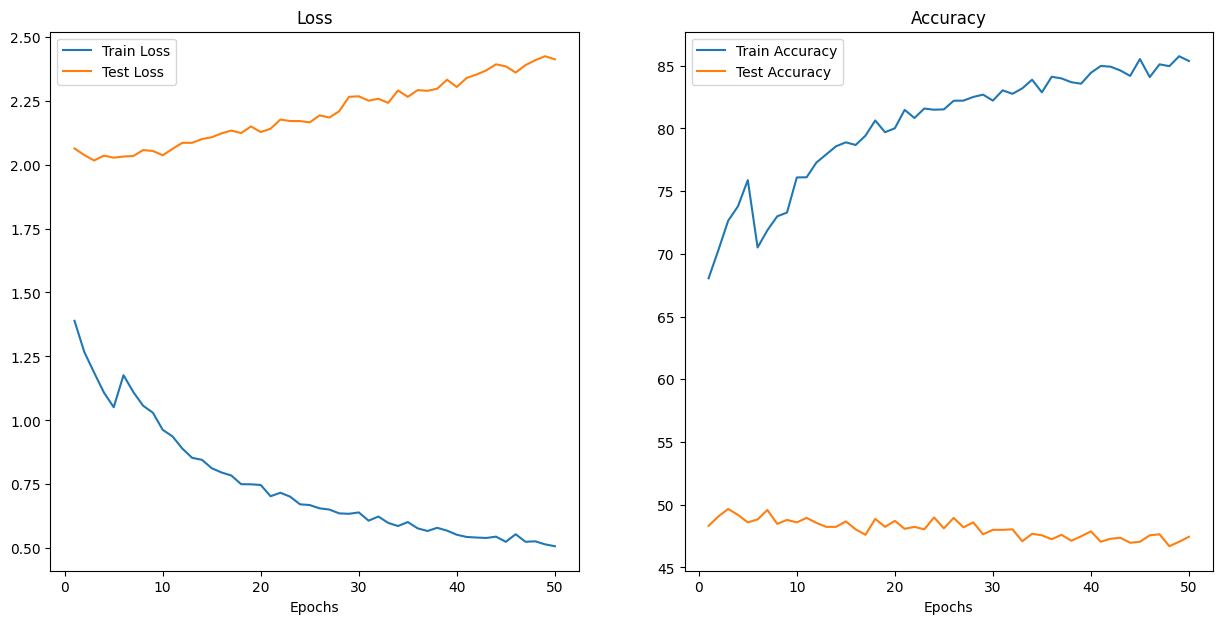

In [ ]:
from typing import Dict, List
import matplotlib.pyplot as plt

def plot_model_lossacc(results: Dict[str,List[int]]):
    ''' 
    Plots Loss and Accuracy curves w.r.t epoch.e
    '''

    train_loss = results['train_loss']
    test_loss = results['test_loss']

    train_acc = results['train_acc']
    test_acc = results['test_acc']

    epochs = results['epoch_count']

    plt.figure(figsize=(15,7))

    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label="Train Loss")
    plt.plot(epochs,test_loss,label="Test Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs,train_acc,label="Train Accuracy")
    plt.plot(epochs,test_acc,label="Test Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

plot_model_lossacc(model_effnetb0_results)

### 5. Testing our model on Custom Data

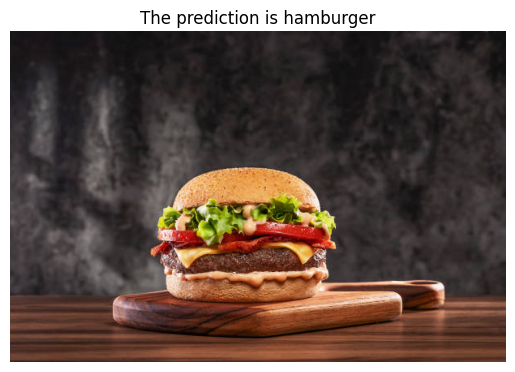

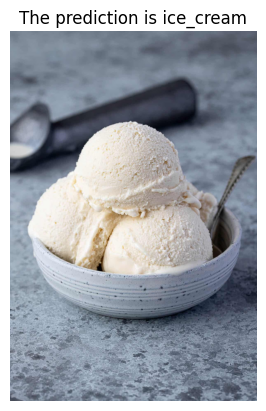

In [ ]:
def pred_and_plot_image(model: nn.Module,
                        image_path: str,
                        class_names: List[str],
                        transform=None,
                        device=device) -> None:
    
    target_image = torchvision.io.read_image(image_path).type(torch.FloatTensor)

    #divide the pixel to get range [0,1]
    target_image_ = target_image/255

    if transform:
        target_image = transform(target_image_)
    
    model.to(device)
    model.eval()
    with torch.inference_mode():
        # extra dimension representing batch
        target_image = target_image.unsqueeze(0) 

        y_pred_logits = model(target_image.to(device))
        y_pred = torch.argmax(torch.softmax(y_pred_logits,dim=1),dim=1)
    plt.figure()
    # plt.imshow(target_image.squeeze().permute(1,2,0).cpu())
    plt.imshow(target_image_.permute(1,2,0))
    plt.title(f"The prediction is {class_names[y_pred]}")
    plt.axis('off')

custom_image_path1 = f"../dataset/Custom_Images/burger_1.jpg"
pred_and_plot_image(model=model_effnetb0,
                    image_path=custom_image_path1,
                    class_names=class_names,
                    transform=auto_transforms_effnetb0,
                    device=device)
custom_image_path2 = f"../dataset/Custom_Images/ice_cream.jpg"
pred_and_plot_image(model=model_effnetb0,
                    image_path=custom_image_path2,
                    class_names=class_names,
                    transform=auto_transforms_effnetb0,
                    device=device)

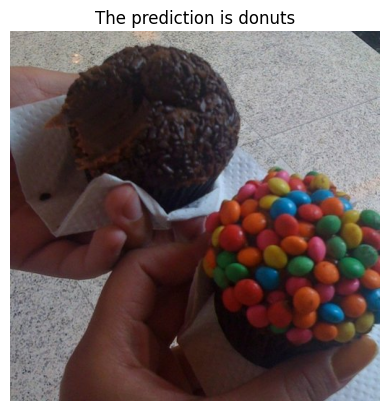

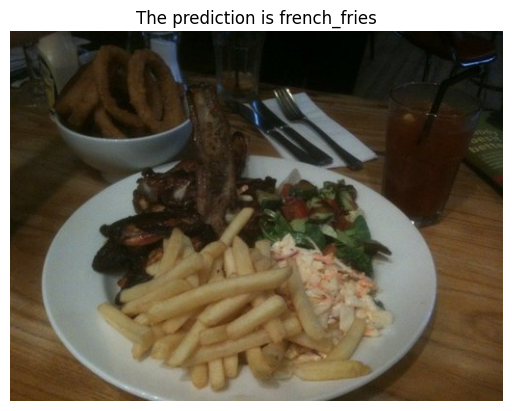

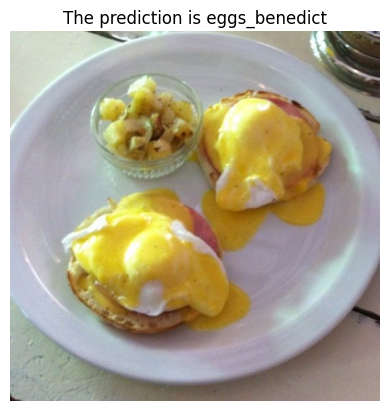

In [ ]:
# lets plot the predictions from test dataset
import random
from pathlib import Path

images_to_plot = 3
test_paths = list(Path(test_dir).glob('*/*.jpg'))
samples = random.sample(population=test_paths,k=images_to_plot)

for image_path in samples:
    pred_and_plot_image(model=model_effnetb0,
                    image_path=image_path,
                    class_names=class_names,
                    transform=auto_transforms_effnetb0,
                    device=device)

EfficientNet_V2_S:

Acc@1: 84.228%, Acc@5: 96.878%, Params: 21.5M, GFLOPS: 8.37


In [24]:
# lets get EfficientNet_v2_S_Weights
weights_effnetV2S = torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1

# getting the transforms used to create the pre-trained weights.
auto_transforms_effnetV2S = weights_effnetV2S.transforms()
auto_transforms_effnetV2S

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [25]:
# getting the transforms used to create the pre-trained weights.
train_dataloader_effnetV2S, test_dataloader_effnetV2S, class_names = create_dataloaders(train_dir=train_dir,
                                                                    test_dir=test_dir,
                                                                    train_transform=auto_transforms_effnetV2S,
                                                                    test_transform=auto_transforms_effnetV2S,
                                                                    batch_size=5,
                                                                    num_workers=1)

In [26]:
model_effnetV2S = torchvision.models.efficientnet_v2_s(weights=weights_effnetV2S)

In [27]:
from torchinfo import summary 
summary(model=model_effnetV2S,
        input_size = (1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 24, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 24, 112, 112]    648                  True
│    │    └─BatchNorm2d (1)                                  [1, 24, 112, 112]    [1, 24, 112, 112]    48                   True
│    │    └─SiLU (2)                                         [1, 24, 112, 112]    [1, 24, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 24, 112, 112]    [1, 24, 112,

In [28]:
# We will be freezing all of the feature layer while training our model, 
# hence these blocks weights will not get updated.

for param in model_effnetV2S.features.parameters():
    param.requires_grad = False 

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# we will only update the classifier head of our model to suit the problem.
model_effnetV2S.classifier = nn.Sequential(nn.Dropout(p=0.2,inplace=True),
                                            nn.Linear(in_features=1280,out_features=640),
                                            nn.ELU(0.01),
                                            nn.Linear(in_features=640,out_features=len(class_names)))

model_effnetV2S = model_effnetV2S.to(device)
summary(model=model_effnetV2S,
        input_size = (1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 24, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 24, 112, 112]    (648)                False
│    │    └─BatchNorm2d (1)                                  [1, 24, 112, 112]    [1, 24, 112, 112]    (48)                 False
│    │    └─SiLU (2)                                         [1, 24, 112, 112]    [1, 24, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 24, 112, 112]    [1, 2

In [30]:
import time
from tqdm.auto import tqdm
from src.utils import create_writer

NUM_EPOCHS = 150
BATCH_SIZE = 5
LEARNING_RATE = 0.001
extra_path = "epochs=" + str(NUM_EPOCHS) + "/batch_size=" + str(BATCH_SIZE) + "/lr=" + str(LEARNING_RATE).replace('.','_') + '/'

torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=model_effnetV2S.parameters(),lr=LEARNING_RATE)
writer = create_writer(experiment_name="MiniFood101",
                       model_name="FE_EffNet_V2_S", # Feature Extraction
                       extra=extra_path)

print("Training Model EffNet_V2_S [Only linear classifier parameters trainable]")
start_time = timer()
model_effnetV2S_results = engine.initiate_training(model=model_effnetV2S,
                                        train_dataloader=train_dataloader_effnetV2S,
                                        test_dataloader=test_dataloader_effnetV2S,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        # scheduler=scheduler1,
                                        epochs=NUM_EPOCHS,
                                        device=device,
                                        writer=writer)       
end_time = timer()

model_training_time = end_time-start_time

model_target_dir = '../models'
formatted_lr = f"lr{str(LEARNING_RATE).rstrip('0').rstrip('.').replace('.', '_')}"
model_name = "FE_EffNet_V2_S_ep" + str(NUM_EPOCHS) + "_bs" + str(BATCH_SIZE) + "_" + formatted_lr + ".pth"

utils.save_model(model=model_effnetV2S,
                 target_dir=model_target_dir,
                 model_name=model_name)

utils.upload_performance(model_name='FE_EffNet_V2_S',
                        target_dir='../model_performance/',
                        batch_size=BATCH_SIZE,
                        learning_rate=LEARNING_RATE,
                        training_time= model_training_time,
                        model_results=model_effnetV2S_results)

Training Model EffNet_V2_S [Only linear classifier parameters trainable]


Epoch 0: Train Loss: 2.2828 | Test Loss: 5.0167 | Train Accuracy: 42.6931 | Test Accuracy: 34.9703


Epoch 1: Train Loss: 2.7237 | Test Loss: 4.6223 | Train Accuracy: 33.3993 | Test Accuracy: 40.9901


Epoch 2: Train Loss: 2.5556 | Test Loss: 3.1016 | Train Accuracy: 36.4884 | Test Accuracy: 42.6535


Epoch 3: Train Loss: 2.3912 | Test Loss: 6.9554 | Train Accuracy: 39.9076 | Test Accuracy: 42.5743


Epoch 4: Train Loss: 2.3327 | Test Loss: 65.2816 | Train Accuracy: 40.8977 | Test Accuracy: 44.1980


Epoch 5: Train Loss: 2.2452 | Test Loss: 14.2102 | Train Accuracy: 43.4191 | Test Accuracy: 41.5446


Epoch 6: Train Loss: 2.1842 | Test Loss: 98.7552 | Train Accuracy: 45.3597 | Test Accuracy: 43.0495


Epoch 7: Train Loss: 2.1415 | Test Loss: 3.2679 | Train Accuracy: 45.5050 | Test Accuracy: 44.1584


Epoch 8: Train Loss: 2.1015 | Test Loss: 110.7054 | Train Accuracy: 46.8911 | Test Accuracy: 44.3960


Epoch 9: Train Loss: 2.0216 | Test Loss: 139.1322 | Train Accuracy: 48.5941 | Test Accuracy: 44.2772


Epoch 10: Train Loss: 1.9962 | Test Loss: 636.6758 | Train Accuracy: 48.6733 | Test Accuracy: 41.3069


Epoch 11: Train Loss: 1.9624 | Test Loss: 31.4165 | Train Accuracy: 48.9373 | Test Accuracy: 44.6733


Epoch 12: Train Loss: 1.9270 | Test Loss: 2.9808 | Train Accuracy: 50.5083 | Test Accuracy: 44.0000


Epoch 13: Train Loss: 1.9140 | Test Loss: 3.0619 | Train Accuracy: 50.6403 | Test Accuracy: 43.3267


Epoch 14: Train Loss: 1.8516 | Test Loss: 3718.8356 | Train Accuracy: 52.5677 | Test Accuracy: 42.8119


Epoch 15: Train Loss: 1.8474 | Test Loss: 115.9274 | Train Accuracy: 52.3564 | Test Accuracy: 42.9703


Epoch 16: Train Loss: 1.8321 | Test Loss: 341.0329 | Train Accuracy: 52.4092 | Test Accuracy: 42.9703


Epoch 17: Train Loss: 1.8252 | Test Loss: 52.2805 | Train Accuracy: 53.9010 | Test Accuracy: 42.7723


Epoch 18: Train Loss: 1.7608 | Test Loss: 193.0821 | Train Accuracy: 53.9802 | Test Accuracy: 42.6139


Epoch 19: Train Loss: 1.7257 | Test Loss: 12.4411 | Train Accuracy: 55.2211 | Test Accuracy: 43.0891


Epoch 20: Train Loss: 1.7528 | Test Loss: 569.1717 | Train Accuracy: 55.4059 | Test Accuracy: 41.1089


Epoch 21: Train Loss: 1.6729 | Test Loss: 3.7005 | Train Accuracy: 56.8713 | Test Accuracy: 44.0396


Epoch 22: Train Loss: 1.7089 | Test Loss: 1644.6434 | Train Accuracy: 55.8416 | Test Accuracy: 44.0396


Epoch 23: Train Loss: 1.7518 | Test Loss: 446.6269 | Train Accuracy: 57.0165 | Test Accuracy: 41.0693


Epoch 24: Train Loss: 1.7240 | Test Loss: 3.6823 | Train Accuracy: 56.5281 | Test Accuracy: 44.5149


Epoch 25: Train Loss: 1.6274 | Test Loss: 2562.6646 | Train Accuracy: 58.2046 | Test Accuracy: 41.5050


Epoch 26: Train Loss: 1.6600 | Test Loss: 3.9133 | Train Accuracy: 57.6898 | Test Accuracy: 43.4059


Epoch 27: Train Loss: 1.6239 | Test Loss: 129.9000 | Train Accuracy: 58.8911 | Test Accuracy: 42.3366


Epoch 28: Train Loss: 1.6308 | Test Loss: 1173.4335 | Train Accuracy: 58.4554 | Test Accuracy: 42.8119


Epoch 29: Train Loss: 1.5770 | Test Loss: 226.1554 | Train Accuracy: 58.7723 | Test Accuracy: 42.6139


Epoch 30: Train Loss: 1.6140 | Test Loss: 270.0131 | Train Accuracy: 59.3135 | Test Accuracy: 42.0990


Epoch 31: Train Loss: 1.5970 | Test Loss: 7.0771 | Train Accuracy: 58.9967 | Test Accuracy: 41.4653


Epoch 32: Train Loss: 1.5374 | Test Loss: 32.0475 | Train Accuracy: 59.9472 | Test Accuracy: 43.9208


Epoch 33: Train Loss: 1.5286 | Test Loss: 1198.6288 | Train Accuracy: 61.2145 | Test Accuracy: 42.7327


Epoch 34: Train Loss: 1.5795 | Test Loss: 4.3012 | Train Accuracy: 60.3828 | Test Accuracy: 43.0891


Epoch 35: Train Loss: 1.5280 | Test Loss: 102.5224 | Train Accuracy: 60.8713 | Test Accuracy: 43.7624


Epoch 36: Train Loss: 1.4865 | Test Loss: 561.1575 | Train Accuracy: 61.4653 | Test Accuracy: 41.7426


Epoch 37: Train Loss: 1.5564 | Test Loss: 1135.9118 | Train Accuracy: 61.6766 | Test Accuracy: 42.0198


Epoch 38: Train Loss: 1.4714 | Test Loss: 2744.8259 | Train Accuracy: 62.6007 | Test Accuracy: 43.7624


Epoch 39: Train Loss: 1.5338 | Test Loss: 2830.5780 | Train Accuracy: 61.3597 | Test Accuracy: 42.9307


Epoch 40: Train Loss: 1.4920 | Test Loss: 685.6188 | Train Accuracy: 62.2574 | Test Accuracy: 43.1683


Epoch 41: Train Loss: 1.4699 | Test Loss: 252.4756 | Train Accuracy: 63.0099 | Test Accuracy: 42.4950


Epoch 42: Train Loss: 1.5339 | Test Loss: 4341.0710 | Train Accuracy: 62.3366 | Test Accuracy: 43.2475


Epoch 43: Train Loss: 1.4419 | Test Loss: 1232.0419 | Train Accuracy: 63.1287 | Test Accuracy: 42.6139


Epoch 44: Train Loss: 1.4573 | Test Loss: 14430.7862 | Train Accuracy: 63.1683 | Test Accuracy: 43.3663


Epoch 45: Train Loss: 1.4637 | Test Loss: 4.9174 | Train Accuracy: 63.4191 | Test Accuracy: 43.4851


Epoch 46: Train Loss: 1.4681 | Test Loss: 68.9405 | Train Accuracy: 63.8812 | Test Accuracy: 42.4554


Epoch 47: Train Loss: 1.4517 | Test Loss: 5.8315 | Train Accuracy: 63.7756 | Test Accuracy: 44.0792


Epoch 48: Train Loss: 1.4402 | Test Loss: 1531.8049 | Train Accuracy: 63.8548 | Test Accuracy: 42.5347


Epoch 49: Train Loss: 1.3985 | Test Loss: 6.7511 | Train Accuracy: 64.7261 | Test Accuracy: 42.7723


Epoch 50: Train Loss: 1.4421 | Test Loss: 329.7851 | Train Accuracy: 64.7789 | Test Accuracy: 42.4554


Epoch 51: Train Loss: 1.4591 | Test Loss: 5420.4075 | Train Accuracy: 63.7228 | Test Accuracy: 41.4653


Epoch 52: Train Loss: 1.4833 | Test Loss: 515.0004 | Train Accuracy: 64.2376 | Test Accuracy: 41.5446


Epoch 53: Train Loss: 1.3895 | Test Loss: 7.0938 | Train Accuracy: 65.7690 | Test Accuracy: 43.2475


Epoch 54: Train Loss: 1.4744 | Test Loss: 1194.4178 | Train Accuracy: 64.5809 | Test Accuracy: 41.5446


Epoch 55: Train Loss: 1.3911 | Test Loss: 108.6843 | Train Accuracy: 65.4125 | Test Accuracy: 42.5743


Epoch 56: Train Loss: 1.3825 | Test Loss: 9.0087 | Train Accuracy: 65.6370 | Test Accuracy: 43.8812


Epoch 57: Train Loss: 1.4046 | Test Loss: 7.6192 | Train Accuracy: 65.2541 | Test Accuracy: 42.6535


Epoch 58: Train Loss: 1.4027 | Test Loss: 1173.2518 | Train Accuracy: 65.1749 | Test Accuracy: 43.0891


Epoch 59: Train Loss: 1.3968 | Test Loss: 244.6834 | Train Accuracy: 65.5842 | Test Accuracy: 43.2871


Epoch 60: Train Loss: 1.3830 | Test Loss: 2564.0334 | Train Accuracy: 66.2970 | Test Accuracy: 43.8416


Epoch 61: Train Loss: 1.3794 | Test Loss: 45.0166 | Train Accuracy: 66.5083 | Test Accuracy: 43.2871


Epoch 62: Train Loss: 1.3713 | Test Loss: 105.3151 | Train Accuracy: 66.2706 | Test Accuracy: 43.6832


Epoch 63: Train Loss: 1.3612 | Test Loss: 103.6251 | Train Accuracy: 66.6007 | Test Accuracy: 43.3267


Epoch 64: Train Loss: 1.3987 | Test Loss: 57.8573 | Train Accuracy: 66.2442 | Test Accuracy: 45.3069


Epoch 65: Train Loss: 1.3773 | Test Loss: 278.8363 | Train Accuracy: 66.6007 | Test Accuracy: 42.4950


Epoch 66: Train Loss: 1.3768 | Test Loss: 2657.7010 | Train Accuracy: 66.7987 | Test Accuracy: 43.6436


Epoch 67: Train Loss: 1.3681 | Test Loss: 1497.5557 | Train Accuracy: 67.2739 | Test Accuracy: 42.3366


Epoch 68: Train Loss: 1.4086 | Test Loss: 135.2975 | Train Accuracy: 66.8779 | Test Accuracy: 44.1980


Epoch 69: Train Loss: 1.3166 | Test Loss: 1571.8670 | Train Accuracy: 67.3531 | Test Accuracy: 43.8416


Epoch 70: Train Loss: 1.3521 | Test Loss: 6.4331 | Train Accuracy: 67.3399 | Test Accuracy: 43.1287


Epoch 71: Train Loss: 1.3647 | Test Loss: 328.1496 | Train Accuracy: 67.0627 | Test Accuracy: 43.6040


Epoch 72: Train Loss: 1.2928 | Test Loss: 160.9512 | Train Accuracy: 68.3828 | Test Accuracy: 43.2475


Epoch 73: Train Loss: 1.3606 | Test Loss: 17.7542 | Train Accuracy: 67.6436 | Test Accuracy: 44.4752


Epoch 74: Train Loss: 1.3684 | Test Loss: 63.0535 | Train Accuracy: 67.7228 | Test Accuracy: 42.6931


Epoch 75: Train Loss: 1.3257 | Test Loss: 372.8796 | Train Accuracy: 68.0528 | Test Accuracy: 43.2871


Epoch 76: Train Loss: 1.3092 | Test Loss: 55.4443 | Train Accuracy: 68.8185 | Test Accuracy: 43.6040


Epoch 77: Train Loss: 1.3344 | Test Loss: 335.6560 | Train Accuracy: 68.2112 | Test Accuracy: 42.8515


Epoch 78: Train Loss: 1.3277 | Test Loss: 103.2647 | Train Accuracy: 68.7261 | Test Accuracy: 43.0891


Epoch 79: Train Loss: 1.3671 | Test Loss: 12.7658 | Train Accuracy: 67.1947 | Test Accuracy: 43.8812


Epoch 80: Train Loss: 1.3159 | Test Loss: 526.7015 | Train Accuracy: 68.8317 | Test Accuracy: 42.9703


Epoch 81: Train Loss: 1.4428 | Test Loss: 106.0690 | Train Accuracy: 68.2112 | Test Accuracy: 43.3267


Epoch 82: Train Loss: 1.3191 | Test Loss: 5.8174 | Train Accuracy: 68.6601 | Test Accuracy: 42.5347


Epoch 83: Train Loss: 1.3102 | Test Loss: 236.0423 | Train Accuracy: 68.6469 | Test Accuracy: 42.8119


Epoch 84: Train Loss: 1.3237 | Test Loss: 123.4947 | Train Accuracy: 68.4884 | Test Accuracy: 43.4059


Epoch 85: Train Loss: 1.3222 | Test Loss: 47.7627 | Train Accuracy: 68.1452 | Test Accuracy: 42.6931


Epoch 86: Train Loss: 1.3181 | Test Loss: 1950.5476 | Train Accuracy: 68.8713 | Test Accuracy: 41.9406


Epoch 87: Train Loss: 1.2646 | Test Loss: 590.5552 | Train Accuracy: 70.0990 | Test Accuracy: 43.6832


Epoch 88: Train Loss: 1.3078 | Test Loss: 193.8858 | Train Accuracy: 69.8350 | Test Accuracy: 44.0396


Epoch 89: Train Loss: 1.2635 | Test Loss: 3607.0597 | Train Accuracy: 69.8086 | Test Accuracy: 44.3168


Epoch 90: Train Loss: 1.2907 | Test Loss: 6.8626 | Train Accuracy: 69.4521 | Test Accuracy: 43.6436


Epoch 91: Train Loss: 1.2775 | Test Loss: 7.9489 | Train Accuracy: 69.4389 | Test Accuracy: 44.2772


Epoch 92: Train Loss: 1.2757 | Test Loss: 774.7477 | Train Accuracy: 69.8086 | Test Accuracy: 41.1089


Epoch 93: Train Loss: 1.2971 | Test Loss: 42.4025 | Train Accuracy: 69.3861 | Test Accuracy: 44.0396


Epoch 94: Train Loss: 1.3419 | Test Loss: 3300.8240 | Train Accuracy: 69.5050 | Test Accuracy: 42.0594


Epoch 95: Train Loss: 1.2993 | Test Loss: 82.9916 | Train Accuracy: 70.0330 | Test Accuracy: 44.3168


Epoch 96: Train Loss: 1.2602 | Test Loss: 1781.1153 | Train Accuracy: 70.1782 | Test Accuracy: 41.5446


Epoch 97: Train Loss: 1.2669 | Test Loss: 6793.2305 | Train Accuracy: 70.1650 | Test Accuracy: 41.5842


Epoch 98: Train Loss: 1.2999 | Test Loss: 6.2576 | Train Accuracy: 69.6502 | Test Accuracy: 44.1584


Epoch 99: Train Loss: 1.2879 | Test Loss: 505.8754 | Train Accuracy: 70.2310 | Test Accuracy: 42.7723


Epoch 100: Train Loss: 1.3132 | Test Loss: 1794.5496 | Train Accuracy: 70.0330 | Test Accuracy: 43.9604


Epoch 101: Train Loss: 1.2709 | Test Loss: 10.3427 | Train Accuracy: 70.6667 | Test Accuracy: 44.6733


Epoch 102: Train Loss: 1.2936 | Test Loss: 363.9320 | Train Accuracy: 69.4125 | Test Accuracy: 43.6436


Epoch 103: Train Loss: 1.2141 | Test Loss: 9.4360 | Train Accuracy: 70.7195 | Test Accuracy: 42.0990


Epoch 104: Train Loss: 1.2908 | Test Loss: 1167.6591 | Train Accuracy: 70.6403 | Test Accuracy: 42.2970


Epoch 105: Train Loss: 1.2975 | Test Loss: 395.5381 | Train Accuracy: 70.3366 | Test Accuracy: 42.2574


Epoch 106: Train Loss: 1.2974 | Test Loss: 138.0072 | Train Accuracy: 70.3366 | Test Accuracy: 42.4950


Epoch 107: Train Loss: 1.2786 | Test Loss: 49.1435 | Train Accuracy: 70.9571 | Test Accuracy: 42.4950


Epoch 108: Train Loss: 1.2513 | Test Loss: 3237.3297 | Train Accuracy: 71.3399 | Test Accuracy: 42.4554


Epoch 109: Train Loss: 1.2732 | Test Loss: 33.4140 | Train Accuracy: 71.0759 | Test Accuracy: 42.6139


Epoch 110: Train Loss: 1.2284 | Test Loss: 731.6913 | Train Accuracy: 72.0792 | Test Accuracy: 42.7327


Epoch 111: Train Loss: 1.2315 | Test Loss: 1069.1202 | Train Accuracy: 71.3399 | Test Accuracy: 42.1782


Epoch 112: Train Loss: 1.2279 | Test Loss: 283.4529 | Train Accuracy: 71.5380 | Test Accuracy: 42.0990


Epoch 113: Train Loss: 1.2654 | Test Loss: 2740.0599 | Train Accuracy: 71.1023 | Test Accuracy: 40.3960


Epoch 114: Train Loss: 1.2824 | Test Loss: 3294.3632 | Train Accuracy: 70.2706 | Test Accuracy: 42.4950


Epoch 115: Train Loss: 1.3816 | Test Loss: 434.2634 | Train Accuracy: 70.1782 | Test Accuracy: 43.7624


Epoch 116: Train Loss: 1.1956 | Test Loss: 6.9127 | Train Accuracy: 72.1980 | Test Accuracy: 43.0495


Epoch 117: Train Loss: 1.2000 | Test Loss: 240.0752 | Train Accuracy: 71.9736 | Test Accuracy: 42.8515


Epoch 118: Train Loss: 1.2271 | Test Loss: 174.5045 | Train Accuracy: 72.1848 | Test Accuracy: 44.4752


Epoch 119: Train Loss: 1.2267 | Test Loss: 308.3728 | Train Accuracy: 71.3267 | Test Accuracy: 41.0297


Epoch 120: Train Loss: 1.2519 | Test Loss: 194.4013 | Train Accuracy: 72.4884 | Test Accuracy: 42.2574


Epoch 121: Train Loss: 1.2103 | Test Loss: 774.1768 | Train Accuracy: 72.7393 | Test Accuracy: 42.2574


Epoch 122: Train Loss: 1.2282 | Test Loss: 206.5666 | Train Accuracy: 72.4488 | Test Accuracy: 44.1980


Epoch 123: Train Loss: 1.2652 | Test Loss: 1189.2085 | Train Accuracy: 71.6436 | Test Accuracy: 40.8713


Epoch 124: Train Loss: 1.1770 | Test Loss: 7.0299 | Train Accuracy: 72.8977 | Test Accuracy: 42.3762


Epoch 125: Train Loss: 1.2166 | Test Loss: 7.4969 | Train Accuracy: 72.8185 | Test Accuracy: 42.2970


Epoch 126: Train Loss: 1.2451 | Test Loss: 862.2754 | Train Accuracy: 71.7360 | Test Accuracy: 42.9307


Epoch 127: Train Loss: 1.2328 | Test Loss: 170.6363 | Train Accuracy: 72.1980 | Test Accuracy: 44.0396


Epoch 128: Train Loss: 1.1880 | Test Loss: 739.1058 | Train Accuracy: 72.4488 | Test Accuracy: 42.5347


Epoch 129: Train Loss: 1.1954 | Test Loss: 41.4334 | Train Accuracy: 73.0033 | Test Accuracy: 43.3663


Epoch 130: Train Loss: 1.1509 | Test Loss: 860.9953 | Train Accuracy: 73.5710 | Test Accuracy: 42.1782


Epoch 131: Train Loss: 1.2601 | Test Loss: 358.7565 | Train Accuracy: 72.7789 | Test Accuracy: 42.1386


Epoch 132: Train Loss: 1.2186 | Test Loss: 176.9552 | Train Accuracy: 73.0033 | Test Accuracy: 41.6238


Epoch 133: Train Loss: 1.1883 | Test Loss: 95.9495 | Train Accuracy: 72.9901 | Test Accuracy: 44.3564


Epoch 134: Train Loss: 1.2568 | Test Loss: 144.1091 | Train Accuracy: 71.9076 | Test Accuracy: 43.5248


Epoch 135: Train Loss: 1.2626 | Test Loss: 1123.6115 | Train Accuracy: 71.6040 | Test Accuracy: 42.2970


Epoch 136: Train Loss: 1.2309 | Test Loss: 35.2397 | Train Accuracy: 72.3696 | Test Accuracy: 42.8119


Epoch 137: Train Loss: 1.2264 | Test Loss: 16.1398 | Train Accuracy: 72.9109 | Test Accuracy: 42.6139


Epoch 138: Train Loss: 1.2780 | Test Loss: 7.2593 | Train Accuracy: 72.6865 | Test Accuracy: 42.7723


Epoch 139: Train Loss: 1.2411 | Test Loss: 1194.0095 | Train Accuracy: 72.0132 | Test Accuracy: 41.4653


Epoch 140: Train Loss: 1.2259 | Test Loss: 111.1333 | Train Accuracy: 72.7393 | Test Accuracy: 43.1287


Epoch 141: Train Loss: 1.1729 | Test Loss: 596.3728 | Train Accuracy: 74.0726 | Test Accuracy: 41.8218


Epoch 142: Train Loss: 1.2714 | Test Loss: 697.7732 | Train Accuracy: 72.5809 | Test Accuracy: 42.8119


Epoch 143: Train Loss: 1.2372 | Test Loss: 161.4705 | Train Accuracy: 73.8482 | Test Accuracy: 43.3267


Epoch 144: Train Loss: 1.2196 | Test Loss: 1916.8519 | Train Accuracy: 73.1089 | Test Accuracy: 43.6832


Epoch 145: Train Loss: 1.1581 | Test Loss: 114.4145 | Train Accuracy: 74.1518 | Test Accuracy: 42.8515


Epoch 146: Train Loss: 1.1819 | Test Loss: 252.8655 | Train Accuracy: 73.0561 | Test Accuracy: 41.8614


Epoch 147: Train Loss: 1.1456 | Test Loss: 1360.5225 | Train Accuracy: 74.4554 | Test Accuracy: 42.9307


Epoch 148: Train Loss: 1.2071 | Test Loss: 11.5073 | Train Accuracy: 73.1617 | Test Accuracy: 41.9802


Epoch 149: Train Loss: 1.1639 | Test Loss: 328.2099 | Train Accuracy: 74.0594 | Test Accuracy: 42.5347
Model results saved successfully! 🚀


In [12]:
from src.utils import save_model

### The Bitter Lesson  
                                                                                                    by Richard Sutton

Richard Sutton, a well-known AI researcher. Argued that the biggest improvements in AI and deep learning have come from leveraging scale (more compute, more data) rather than relying on human-designed heuristics or handcrafted features.

- Scaling Wins Over Manual Engineering

    - Historically, attempts to encode human knowledge into AI models (like expert systems or feature engineering) have been outperformed by methods that simply scale up computation and data.
    - Example: In computer vision, early approaches used handcrafted features like SIFT and HOG. But deep learning (CNNs) crushed them by just learning from large datasets.

- End-to-End Learning is More Effective

    - Models that learn directly from raw data often outperform those that rely on manually structured representations.
    - Example: Instead of designing rules for speech recognition, modern models (like transformers) just learn from vast amounts of speech data.

- Computation is the Real Game Changer

    - As compute power grows, brute-force approaches tend to outperform human-designed optimizations.
    - Example: Chess engines went from human-crafted rules to reinforcement learning-based systems like AlphaZero, which learned by playing against itself.

* How It Relates to Deep Learning Models Today

    - Transformers in NLP → The shift from rule-based or RNN-based models to massive transformer models (GPT, BERT, etc.), which work better simply because they scale with more data and compute.
    - Vision Models → CNNs and now Vision Transformers (ViTs) outperform older manually designed vision algorithms because they learn directly from data.
    - Reinforcement Learning (RL) → AlphaGo and MuZero didn’t rely on human-designed heuristics but instead trained through massive compute.




## Experiments on the Models

Lets train all the parameters of EfficientNetB0

In [5]:
# lets get the pre-trained model weights
weights_effnetb0_2 = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1

# getting the transforms used to create the pre-trained weights.
auto_transforms_effnetb0_2 = weights_effnetb0_2.transforms()
print(auto_transforms_effnetb0_2)

train_dataloader_effnetb0_2, test_dataloader_effnetb0_2, class_names = create_dataloaders(train_dir=train_dir,
                                                                                      test_dir=test_dir,
                                                                                      train_transform=auto_transforms_effnetb0_2,
                                                                                      test_transform=auto_transforms_effnetb0_2,
                                                                                      batch_size=5,
                                                                                      num_workers=1)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [6]:
model_effnetb0_2 = torchvision.models.efficientnet_b0(weights=weights_effnetb0_2)

model_effnetb0_2.classifier = nn.Sequential(nn.Dropout(p=0.2,inplace=True),
                                            nn.Linear(in_features=1280,out_features=640),
                                            nn.ELU(0.01),
                                            nn.Linear(in_features=640,out_features=len(class_names)))
model_effnetb0_2 = model_effnetb0_2.to(device)

summary(model=model_effnetb0_2,
        input_size = (1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [7]:
device = next(model_effnetb0_2.parameters()).device
print(device)

cuda:0


In [15]:
import time
from tqdm.auto import tqdm
from src.utils import create_writer

BATCH_SIZE = 5
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
extra_path = "epochs=" + str(NUM_EPOCHS) + "/batch_size=" + str(BATCH_SIZE) + "/lr=" + str(LEARNING_RATE).replace('.','_') + '/'
print(extra_path)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=model_effnetb0_2.parameters(),lr=0.001)
writer = create_writer(experiment_name="MiniFood101",
                       model_name="EffNetB0",
                       extra=extra_path)

print("Training Model EffnetB0 [all parameters trained]")
start_time = timer()
model_effnetb0_2_results = engine.initiate_training(model=model_effnetb0_2,
                                        train_dataloader=train_dataloader_effnetb0_2,
                                        test_dataloader=test_dataloader_effnetb0_2,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        # scheduler=scheduler1,
                                        epochs=NUM_EPOCHS,
                                        device=device,
                                        writer=writer)       
end_time = timer()

model_training_time = end_time-start_time
model_target_dir = '../models'
formatted_lr = f"lr{str(LEARNING_RATE).rstrip('0').rstrip('.').replace('.', '_')}"
model_name = "EffNet_B0_ep" + str(NUM_EPOCHS) + "_bs" + str(BATCH_SIZE) + "_" + formatted_lr + ".pth"

utils.save_model(model=model_effnetb0_2,
                 target_dir=model_target_dir,
                 model_name=model_name)

utils.upload_performance(model_name='EfficientNet_B0',
                        target_dir='../model_performance/',
                        batch_size=BATCH_SIZE,
                        learning_rate=LEARNING_RATE,
                        training_time= model_training_time,
                        model_results=model_effnetb0_2_results)


epochs=50/batch_size=5/lr=0_001/
Training Model EffnetB0 [all parameters trained]


Epoch 0: Train Loss: 4.1406 | Test Loss: 3.9628 | Train Accuracy: 5.8746 | Test Accuracy: 8.3168


Epoch 1: Train Loss: 4.0764 | Test Loss: 3.8186 | Train Accuracy: 6.8911 | Test Accuracy: 9.5050


Epoch 2: Train Loss: 3.9634 | Test Loss: 3.6637 | Train Accuracy: 8.3828 | Test Accuracy: 11.5248


Epoch 3: Train Loss: 3.8415 | Test Loss: 3.6289 | Train Accuracy: 9.7822 | Test Accuracy: 12.5545


Epoch 4: Train Loss: 3.7020 | Test Loss: 3.5042 | Train Accuracy: 11.7096 | Test Accuracy: 14.8515


Epoch 5: Train Loss: 3.5558 | Test Loss: 3.4117 | Train Accuracy: 14.0858 | Test Accuracy: 16.8317


Epoch 6: Train Loss: 3.4028 | Test Loss: 3.4479 | Train Accuracy: 16.3300 | Test Accuracy: 17.2277


Epoch 7: Train Loss: 3.2740 | Test Loss: 3.2376 | Train Accuracy: 18.3894 | Test Accuracy: 20.8317


Epoch 8: Train Loss: 3.1038 | Test Loss: 3.4472 | Train Accuracy: 21.6238 | Test Accuracy: 19.8416


Epoch 9: Train Loss: 2.9467 | Test Loss: 3.2300 | Train Accuracy: 23.8152 | Test Accuracy: 22.0594


Epoch 10: Train Loss: 2.8007 | Test Loss: 3.3730 | Train Accuracy: 25.8746 | Test Accuracy: 22.1782


Epoch 11: Train Loss: 2.6548 | Test Loss: 3.3186 | Train Accuracy: 28.6997 | Test Accuracy: 21.9406


Epoch 12: Train Loss: 2.5055 | Test Loss: 3.5624 | Train Accuracy: 32.5809 | Test Accuracy: 20.5149


Epoch 13: Train Loss: 2.3638 | Test Loss: 3.6423 | Train Accuracy: 35.1947 | Test Accuracy: 22.5743


Epoch 14: Train Loss: 2.2388 | Test Loss: 3.6282 | Train Accuracy: 38.4290 | Test Accuracy: 24.0000


Epoch 15: Train Loss: 2.0965 | Test Loss: 3.5973 | Train Accuracy: 41.4389 | Test Accuracy: 23.8416


Epoch 16: Train Loss: 1.9388 | Test Loss: 3.7060 | Train Accuracy: 44.7789 | Test Accuracy: 22.9307


Epoch 17: Train Loss: 1.8487 | Test Loss: 3.7912 | Train Accuracy: 46.8119 | Test Accuracy: 22.6931


Epoch 18: Train Loss: 1.7183 | Test Loss: 3.7708 | Train Accuracy: 49.8878 | Test Accuracy: 23.2871


Epoch 19: Train Loss: 1.5596 | Test Loss: 4.0053 | Train Accuracy: 54.2838 | Test Accuracy: 23.1287


Epoch 20: Train Loss: 1.4807 | Test Loss: 4.2306 | Train Accuracy: 55.5908 | Test Accuracy: 22.6931


Epoch 21: Train Loss: 1.3894 | Test Loss: 4.6183 | Train Accuracy: 58.7723 | Test Accuracy: 20.9505


Epoch 22: Train Loss: 1.3565 | Test Loss: 4.3103 | Train Accuracy: 59.9076 | Test Accuracy: 23.0099


Epoch 23: Train Loss: 1.2482 | Test Loss: 4.4043 | Train Accuracy: 62.2706 | Test Accuracy: 22.3762


Epoch 24: Train Loss: 1.1857 | Test Loss: 4.7817 | Train Accuracy: 64.3036 | Test Accuracy: 21.2673


Epoch 25: Train Loss: 1.1376 | Test Loss: 4.5906 | Train Accuracy: 65.8218 | Test Accuracy: 22.8911


Epoch 26: Train Loss: 1.0958 | Test Loss: 5.1272 | Train Accuracy: 66.1254 | Test Accuracy: 20.5545


Epoch 27: Train Loss: 0.9823 | Test Loss: 5.1664 | Train Accuracy: 69.9274 | Test Accuracy: 21.7426


Epoch 28: Train Loss: 0.9398 | Test Loss: 5.2249 | Train Accuracy: 70.9439 | Test Accuracy: 20.7129


Epoch 29: Train Loss: 0.9312 | Test Loss: 4.9699 | Train Accuracy: 72.1188 | Test Accuracy: 21.9802


Epoch 30: Train Loss: 0.8880 | Test Loss: 5.4428 | Train Accuracy: 72.7525 | Test Accuracy: 20.9109


Epoch 31: Train Loss: 0.8419 | Test Loss: 5.4816 | Train Accuracy: 75.1023 | Test Accuracy: 20.4752


Epoch 32: Train Loss: 0.8041 | Test Loss: 5.5970 | Train Accuracy: 74.5347 | Test Accuracy: 20.6733


Epoch 33: Train Loss: 0.7697 | Test Loss: 5.7335 | Train Accuracy: 77.4125 | Test Accuracy: 21.3069


Epoch 34: Train Loss: 0.7760 | Test Loss: 5.8815 | Train Accuracy: 76.1980 | Test Accuracy: 19.4851


Epoch 35: Train Loss: 0.7200 | Test Loss: 5.7171 | Train Accuracy: 78.1914 | Test Accuracy: 19.8020


Epoch 36: Train Loss: 0.6802 | Test Loss: 5.9693 | Train Accuracy: 79.6700 | Test Accuracy: 21.3465


Epoch 37: Train Loss: 0.6682 | Test Loss: 6.1523 | Train Accuracy: 79.1023 | Test Accuracy: 20.2376


Epoch 38: Train Loss: 0.6889 | Test Loss: 6.0675 | Train Accuracy: 78.4290 | Test Accuracy: 18.9703


Epoch 39: Train Loss: 0.6431 | Test Loss: 5.9059 | Train Accuracy: 80.0132 | Test Accuracy: 20.1188


Epoch 40: Train Loss: 0.6059 | Test Loss: 6.1935 | Train Accuracy: 81.1881 | Test Accuracy: 19.8812


Epoch 41: Train Loss: 0.6249 | Test Loss: 5.9750 | Train Accuracy: 81.0693 | Test Accuracy: 19.3663


Epoch 42: Train Loss: 0.6350 | Test Loss: 6.1542 | Train Accuracy: 80.5281 | Test Accuracy: 20.9505


Epoch 43: Train Loss: 0.5544 | Test Loss: 6.3317 | Train Accuracy: 82.8779 | Test Accuracy: 20.9901


Epoch 44: Train Loss: 0.5789 | Test Loss: 6.0237 | Train Accuracy: 81.5050 | Test Accuracy: 20.9505


Epoch 45: Train Loss: 0.5487 | Test Loss: 7.3103 | Train Accuracy: 83.0891 | Test Accuracy: 18.7723


Epoch 46: Train Loss: 0.5401 | Test Loss: 6.3123 | Train Accuracy: 83.1155 | Test Accuracy: 20.1584


Epoch 47: Train Loss: 0.5493 | Test Loss: 6.1823 | Train Accuracy: 82.8779 | Test Accuracy: 21.3069


Epoch 48: Train Loss: 0.5389 | Test Loss: 6.5017 | Train Accuracy: 83.4455 | Test Accuracy: 20.5149


Epoch 49: Train Loss: 0.5495 | Test Loss: 6.7478 | Train Accuracy: 83.2343 | Test Accuracy: 21.2277
Model results saved successfully! 🚀


Training all the parameters of EfficientNet_V2_S

In [16]:
weights_effnetV2S = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT

model_effnetV2S_2 = torchvision.models.efficientnet_v2_s(weights=weights_effnetV2S)


# getting the transforms used to create the pre-trained weights.
auto_transforms_effnetV2S_2 = weights_effnetV2S.transforms()

train_dataloader_effnetV2S_2, test_dataloader_effnetV2S_2, class_names = create_dataloaders(train_dir=train_dir,
                                                                                            test_dir=test_dir,
                                                                                            train_transform=auto_transforms_effnetV2S_2,
                                                                                            test_transform=auto_transforms_effnetV2S_2,
                                                                                            batch_size=5,
                                                                                            num_workers=1)

model_effnetV2S_2.classifier = nn.Sequential(nn.Dropout(p=0.2,inplace=True),
                                            nn.Linear(in_features=1280,out_features=640),
                                            nn.ELU(0.01),
                                            nn.Linear(in_features=640,out_features=len(class_names)))

model_effnetV2S_2 = model_effnetV2S_2.to(device)

summary(model=model_effnetV2S_2,
        input_size = (1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 24, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 24, 112, 112]    648                  True
│    │    └─BatchNorm2d (1)                                  [1, 24, 112, 112]    [1, 24, 112, 112]    48                   True
│    │    └─SiLU (2)                                         [1, 24, 112, 112]    [1, 24, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 24, 112, 112]    [1, 24, 112,

In [9]:
device = next(model_effnetV2S_2.parameters()).device
print(device)
print(auto_transforms_effnetV2S_2)

cuda:0
ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
import time
from tqdm.auto import tqdm
from src.utils import create_writer

NUM_EPOCHS = 50
BATCH_SIZE = 5
LEARNING_RATE = 0.001
extra_path = "epochs=" + str(NUM_EPOCHS) + "/batch_size=" + str(BATCH_SIZE) + "/lr=" + str(LEARNING_RATE).replace('.','_') + '/'

torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=model_effnetV2S_2.parameters(),lr=LEARNING_RATE)
writer = create_writer(experiment_name="MiniFood101",
                       model_name="EffNet_V2_S", # Feature Extraction
                       extra=extra_path)

print("Training Model EffNet_V2_S [All parameters trainable]")
start_time = timer()
model_effnetV2S_2_results = engine.initiate_training(model=model_effnetV2S_2,
                                        train_dataloader=train_dataloader_effnetV2S_2,
                                        test_dataloader=test_dataloader_effnetV2S_2,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        # scheduler=scheduler1,
                                        epochs=NUM_EPOCHS,
                                        device=device,
                                        writer=writer)       
end_time = timer()

model_training_time = end_time-start_time

model_target_dir = '../models'
formatted_lr = f"lr{str(LEARNING_RATE).rstrip('0').rstrip('.').replace('.', '_')}"
model_name = "EffNet_V2_S_ep" + str(NUM_EPOCHS) + "_bs" + str(BATCH_SIZE) + "_" + formatted_lr + ".pth"

utils.save_model(model=model_effnetV2S_2,
                 target_dir=model_target_dir,
                 model_name=model_name)

utils.upload_performance(model_name='EfficientNet_V2_S',
                        target_dir='../model_performance/',                        batch_size=BATCH_SIZE,
                        learning_rate=LEARNING_RATE,
                        training_time= model_training_time,
                        model_results=model_effnetV2S_2_results)

Training Model EffNet_V2_S [All parameters trainable]


Epoch 0: Train Loss: 4.6346 | Test Loss: 4.6230 | Train Accuracy: 0.8713 | Test Accuracy: 0.9901


Epoch 1: Train Loss: 4.6310 | Test Loss: 4.6179 | Train Accuracy: 1.0957 | Test Accuracy: 1.1089


Epoch 2: Train Loss: 4.6304 | Test Loss: 4.6184 | Train Accuracy: 0.6469 | Test Accuracy: 0.9901


Epoch 3: Train Loss: 4.6308 | Test Loss: 4.6192 | Train Accuracy: 0.8845 | Test Accuracy: 0.9901


Epoch 4: Train Loss: 4.6284 | Test Loss: 4.6306 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 5: Train Loss: 4.6306 | Test Loss: 4.6241 | Train Accuracy: 0.8713 | Test Accuracy: 0.9901


Epoch 6: Train Loss: 4.6274 | Test Loss: 4.6190 | Train Accuracy: 0.8053 | Test Accuracy: 0.9901


Epoch 7: Train Loss: 4.6304 | Test Loss: 4.6087 | Train Accuracy: 0.8053 | Test Accuracy: 1.5842


Epoch 8: Train Loss: 4.6008 | Test Loss: 4.5182 | Train Accuracy: 1.6106 | Test Accuracy: 1.7426


Epoch 9: Train Loss: 4.5435 | Test Loss: 4.4726 | Train Accuracy: 1.8878 | Test Accuracy: 2.3762


Epoch 10: Train Loss: 4.5115 | Test Loss: 4.6072 | Train Accuracy: 2.0066 | Test Accuracy: 1.5842


Epoch 11: Train Loss: 4.5000 | Test Loss: 4.4361 | Train Accuracy: 1.9142 | Test Accuracy: 2.5347


Epoch 12: Train Loss: 4.4720 | Test Loss: 4.3954 | Train Accuracy: 2.5611 | Test Accuracy: 3.0495


Epoch 13: Train Loss: 4.4399 | Test Loss: 4.3877 | Train Accuracy: 2.7195 | Test Accuracy: 3.1683


Epoch 14: Train Loss: 4.4189 | Test Loss: 4.3159 | Train Accuracy: 2.4422 | Test Accuracy: 4.1188


Epoch 15: Train Loss: 4.3691 | Test Loss: 4.2999 | Train Accuracy: 3.2079 | Test Accuracy: 4.4356


Epoch 16: Train Loss: 4.3012 | Test Loss: 4.2915 | Train Accuracy: 3.9868 | Test Accuracy: 5.5842


Epoch 17: Train Loss: 4.2564 | Test Loss: 4.1514 | Train Accuracy: 4.6205 | Test Accuracy: 6.5347


Epoch 18: Train Loss: 4.2092 | Test Loss: 4.1266 | Train Accuracy: 4.9109 | Test Accuracy: 6.6139


Epoch 19: Train Loss: 4.1784 | Test Loss: 4.0821 | Train Accuracy: 5.4653 | Test Accuracy: 6.3762


Epoch 20: Train Loss: 4.1464 | Test Loss: 4.0641 | Train Accuracy: 5.6238 | Test Accuracy: 7.3663


Epoch 21: Train Loss: 4.1163 | Test Loss: 4.0075 | Train Accuracy: 6.0066 | Test Accuracy: 7.8020


Epoch 22: Train Loss: 4.0790 | Test Loss: 3.9910 | Train Accuracy: 6.5083 | Test Accuracy: 7.2079


Epoch 23: Train Loss: 4.0372 | Test Loss: 3.9947 | Train Accuracy: 7.2739 | Test Accuracy: 8.3960


Epoch 24: Train Loss: 3.9889 | Test Loss: 3.9164 | Train Accuracy: 7.9736 | Test Accuracy: 8.5941


Epoch 25: Train Loss: 3.9607 | Test Loss: 3.8975 | Train Accuracy: 7.8680 | Test Accuracy: 9.9010


Epoch 26: Train Loss: 3.9093 | Test Loss: 3.8600 | Train Accuracy: 8.8977 | Test Accuracy: 10.0198


Epoch 27: Train Loss: 3.8578 | Test Loss: 3.8578 | Train Accuracy: 9.6634 | Test Accuracy: 10.5743


Epoch 28: Train Loss: 3.8152 | Test Loss: 3.8295 | Train Accuracy: 10.1518 | Test Accuracy: 12.6733


Epoch 29: Train Loss: 3.7608 | Test Loss: 3.7907 | Train Accuracy: 11.0891 | Test Accuracy: 12.8317


Epoch 30: Train Loss: 3.7315 | Test Loss: 3.7369 | Train Accuracy: 11.8152 | Test Accuracy: 12.8317


Epoch 31: Train Loss: 3.6742 | Test Loss: 3.7514 | Train Accuracy: 12.6469 | Test Accuracy: 12.7921


Epoch 32: Train Loss: 3.6083 | Test Loss: 3.7641 | Train Accuracy: 13.2673 | Test Accuracy: 12.6733


Epoch 33: Train Loss: 3.5774 | Test Loss: 3.7862 | Train Accuracy: 13.9406 | Test Accuracy: 12.8317


Epoch 34: Train Loss: 3.5154 | Test Loss: 3.7383 | Train Accuracy: 14.3630 | Test Accuracy: 12.7921


Epoch 35: Train Loss: 3.4586 | Test Loss: 3.7258 | Train Accuracy: 15.6436 | Test Accuracy: 14.0198


Epoch 36: Train Loss: 3.4038 | Test Loss: 3.8225 | Train Accuracy: 16.6733 | Test Accuracy: 13.9802


Epoch 37: Train Loss: 3.3477 | Test Loss: 3.7401 | Train Accuracy: 17.3465 | Test Accuracy: 13.3861


Epoch 38: Train Loss: 3.3088 | Test Loss: 3.8783 | Train Accuracy: 18.0462 | Test Accuracy: 12.9505


Epoch 39: Train Loss: 3.2309 | Test Loss: 3.8558 | Train Accuracy: 19.1815 | Test Accuracy: 14.0594


Epoch 40: Train Loss: 3.1779 | Test Loss: 3.7905 | Train Accuracy: 19.9076 | Test Accuracy: 12.9109


Epoch 41: Train Loss: 3.1357 | Test Loss: 3.7613 | Train Accuracy: 20.4884 | Test Accuracy: 15.2871


Epoch 42: Train Loss: 3.0692 | Test Loss: 4.0254 | Train Accuracy: 21.9406 | Test Accuracy: 13.7822


Epoch 43: Train Loss: 2.9859 | Test Loss: 3.9401 | Train Accuracy: 23.4851 | Test Accuracy: 14.4158


Epoch 44: Train Loss: 2.9385 | Test Loss: 3.9004 | Train Accuracy: 24.8053 | Test Accuracy: 14.1386


Epoch 45: Train Loss: 2.8429 | Test Loss: 4.0252 | Train Accuracy: 26.5083 | Test Accuracy: 14.1782


Epoch 46: Train Loss: 2.7919 | Test Loss: 4.0786 | Train Accuracy: 27.0099 | Test Accuracy: 13.4257


Epoch 47: Train Loss: 2.7011 | Test Loss: 4.2530 | Train Accuracy: 28.8713 | Test Accuracy: 14.3366


Epoch 48: Train Loss: 2.6449 | Test Loss: 4.5417 | Train Accuracy: 30.3234 | Test Accuracy: 14.6931


Epoch 49: Train Loss: 2.5580 | Test Loss: 4.4589 | Train Accuracy: 31.4059 | Test Accuracy: 14.0990
Model results saved successfully! 🚀
